In [10]:
import pandas as pd 
import numpy as np
import math
import itertools
from itertools import compress
import geopandas as gpd

import os
from glob import glob
from tqdm import tqdm
import dtw

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
import math

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from minisom import MiniSom

import warnings
warnings.filterwarnings("ignore")

import sys
import os

sys.path.append('scripts')

# **Data Prep**

In [17]:
training = pd.read_pickle('../../../04_Data_Preprocessing/training-test/32/training_imputation_32_VH_recode2.pkl')
testing  = pd.read_pickle('../../../04_Data_Preprocessing/training-test/32/testing_imputation_32_VH_recode2.pkl')
cluster  = gpd.read_file('../../../00_Data_Input/cluster_data/cluster_32_ok.gpkg')

training.head()

,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_7,VH_6,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,year,date
0,320201009A1#01,320201009A1,320201009,1,2022_03,NV,48MXS,-13.950575,-13.704084,-13.918890,...,-13.482984,-12.038650,-12.308728,-12.026812,-12.877756,-14.129539,-13.121758,-13.279804,22,2022-01-01
1,320201009A1#02,320201009A1,320201009,1,2022_03,NV,48MXS,-12.331718,-11.972934,-12.526777,...,-12.722636,-12.356975,-11.897697,-11.334288,-12.226791,-13.437385,-12.356170,-13.047971,22,2022-01-01
2,320201009A1#03,320201009A1,320201009,1,2022_03,NV,48MXS,-11.529987,-11.416285,-12.503205,...,-13.417534,-13.683514,-13.061878,-12.575087,-12.567230,-12.675266,-12.290981,-13.212626,22,2022-01-01
3,320201009A1#04,320201009A1,320201009,1,2022_03,NV,48MXS,-13.361443,-13.600700,-14.267582,...,-14.324576,-15.200937,-13.972915,-12.964134,-12.838857,-12.582704,-12.307726,-12.659531,22,2022-01-01
4,320201009A1#05,320201009A1,320201009,1,2022_03,NV,48MXS,-12.995016,-13.444426,-13.876660,...,-14.734580,-15.240816,-14.630651,-14.336236,-13.393566,-12.625300,-12.127337,-12.909364,22,2022-01-01


In [18]:
training['idkab'] = training['idpoint'].str[:4]
testing['idkab'] = testing['idpoint'].str[:4]
testing = testing.merge(cluster[['idkab','cluster_data']], how='right', on='idkab')

training = training.loc[training['observation']!='P']
testing = testing.loc[testing['observation']!='P']

training = training.dropna()
testing = testing.dropna()

testing.head()

,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,year,date,idkab,cluster_data
0,320130009A1#01,320130009A1,320130009,10,2023_25,BP,48MXU,-16.725023,-17.835718,-18.861912,...,-16.753235,-15.073020,-12.567095,-15.945707,-19.707195,-14.096098,23,2023-10-01,3201,0
1,320130009A1#02,320130009A1,320130009,10,2023_25,BP,48MXU,-17.029100,-18.132090,-19.203442,...,-16.679087,-15.764339,-13.903972,-16.411623,-19.349918,-14.618581,23,2023-10-01,3201,0
2,320130009A1#03,320130009A1,320130009,10,2023_25,BP,48MXU,-16.883081,-18.095416,-19.142895,...,-17.516607,-15.456612,-12.541103,-15.449263,-17.949583,-15.539997,23,2023-10-01,3201,0
3,320130009A1#04,320130009A1,320130009,10,2023_25,BP,48MXU,-16.310753,-17.412438,-18.193932,...,-17.875544,-15.436776,-12.406763,-15.630909,-18.461334,-15.473708,23,2023-10-01,3201,0
4,320130009A1#05,320130009A1,320130009,10,2023_25,BP,48MXU,-16.897139,-17.672377,-18.074509,...,-18.206902,-16.664985,-14.854314,-16.607943,-17.888708,-16.222599,23,2023-10-01,3201,0


In [13]:
conditions = {
    'V1':1,
    'V2':2,
    'G':3,
    'H':4,
    'BP':0,
    'PL':5,
    'BPL':0,
    'NP':7,
    'NV':7
}

training['observation2'] = training['observation'].map(conditions)
testing['observation2'] = testing['observation'].map(conditions)

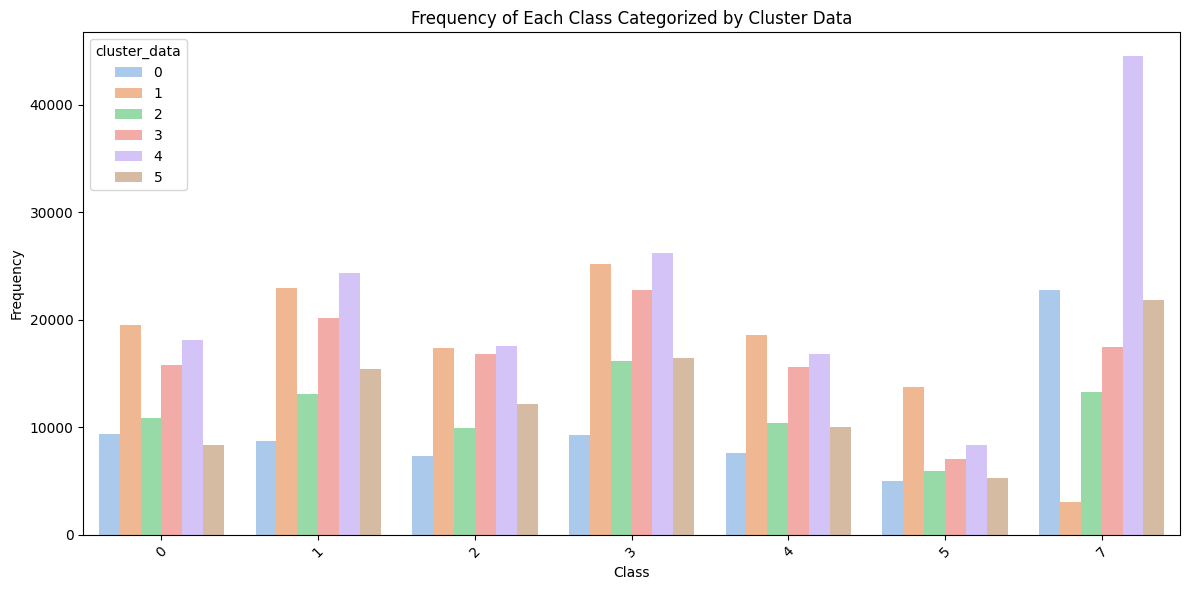

In [14]:
class_counts_clustered = training.groupby(['observation2', 'cluster_data']).size().reset_index(name='counts')

plt.figure(figsize=(12, 6))
sns.barplot(data=class_counts_clustered, x='observation2', y='counts', hue='cluster_data', palette='pastel')

plt.title('Frequency of Each Class Categorized by Cluster Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### **Undersampling - Stratified by cluster and class**

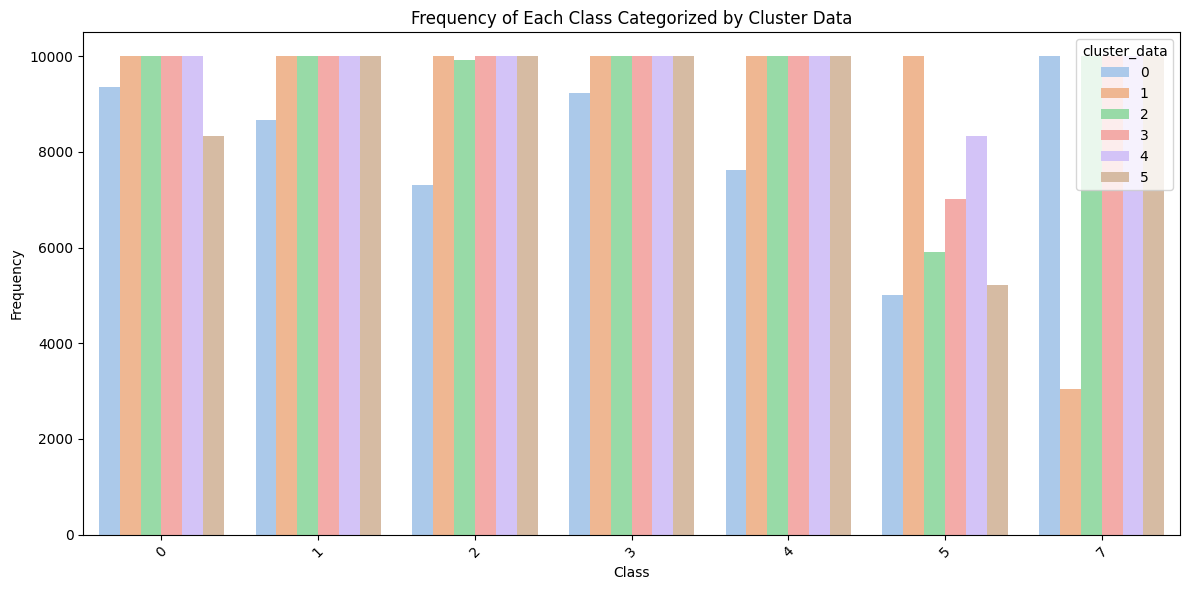

In [102]:
training_sampled = training.groupby(['observation2','cluster_data'], group_keys=False).apply(lambda x: x.sample(min(len(x), 10000)))

class_counts_clustered = training_sampled.groupby(['observation2', 'cluster_data']).size().reset_index(name='counts')

plt.figure(figsize=(12, 6))
sns.barplot(data=class_counts_clustered, x='observation2', y='counts', hue='cluster_data', palette='pastel')

plt.title('Frequency of Each Class Categorized by Cluster Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Data yang bersih adalah data **training_sampled**

# **Modeling**

In [7]:
from script_model import modeling

ModuleNotFoundError: No module named 'script_model'

### Definisikan Variabel

In [104]:
var_ = list(training.loc[:,'VH_30':'VH_0'].columns.values) + ['nth']

### Simpan Model tiap cluster dalam bentuk dictionary

Processing Random Forest...cluster_0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:

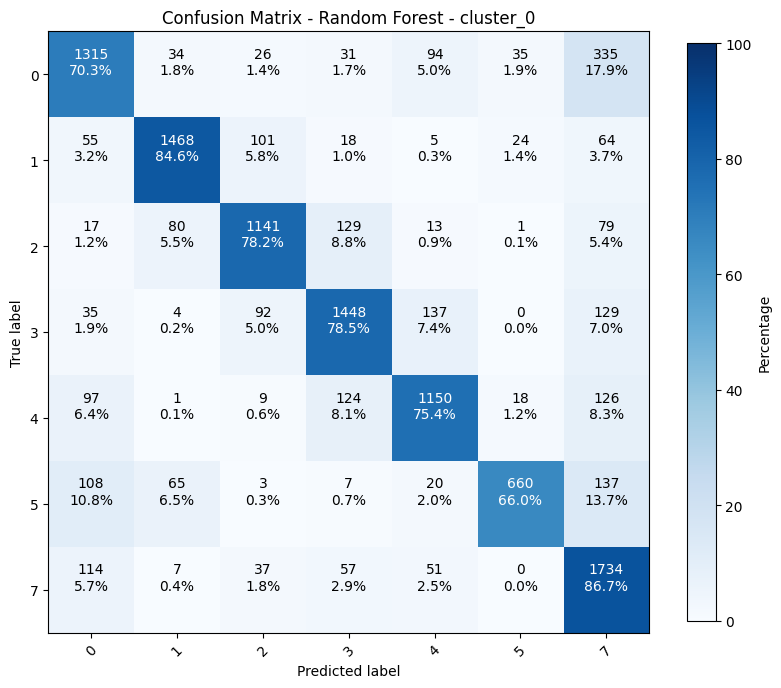

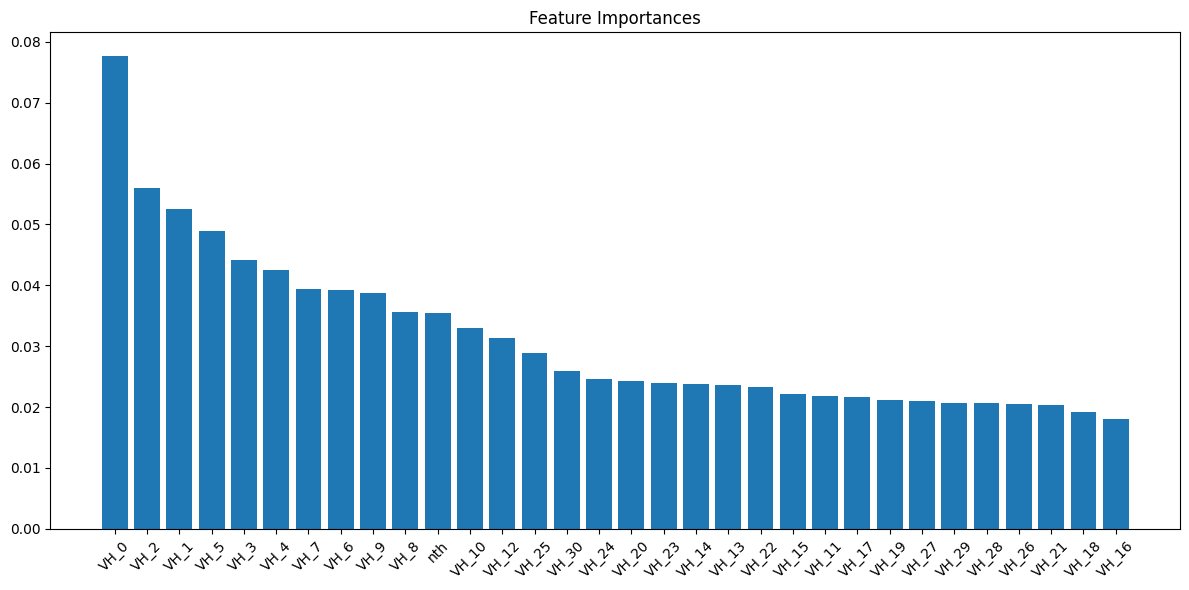

Processing Random Forest...cluster_1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=64)]: Done 100 out of 100

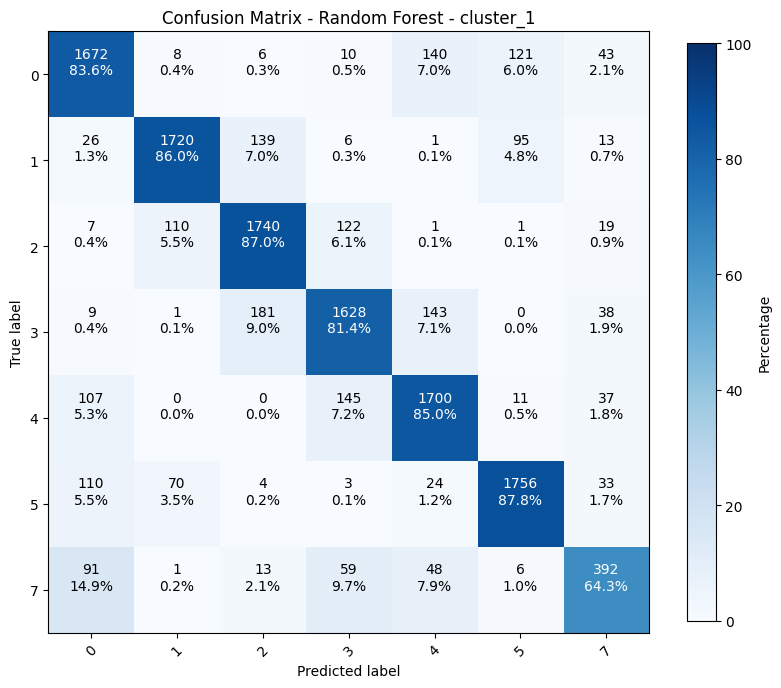

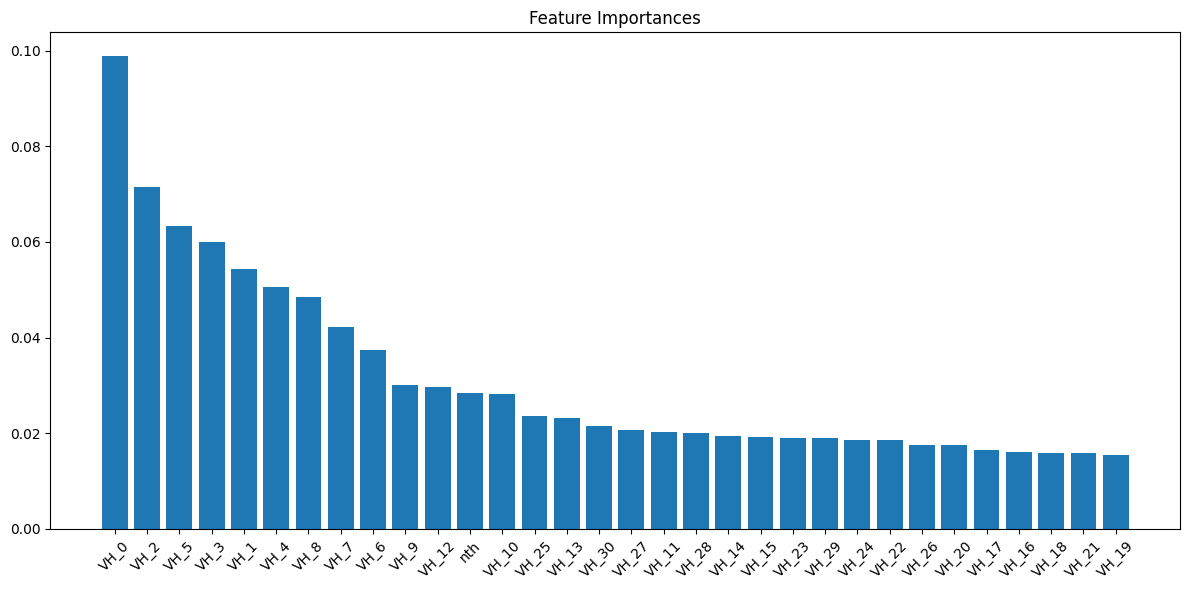

Processing Random Forest...cluster_2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    5.0s remaining:    1.8s
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100

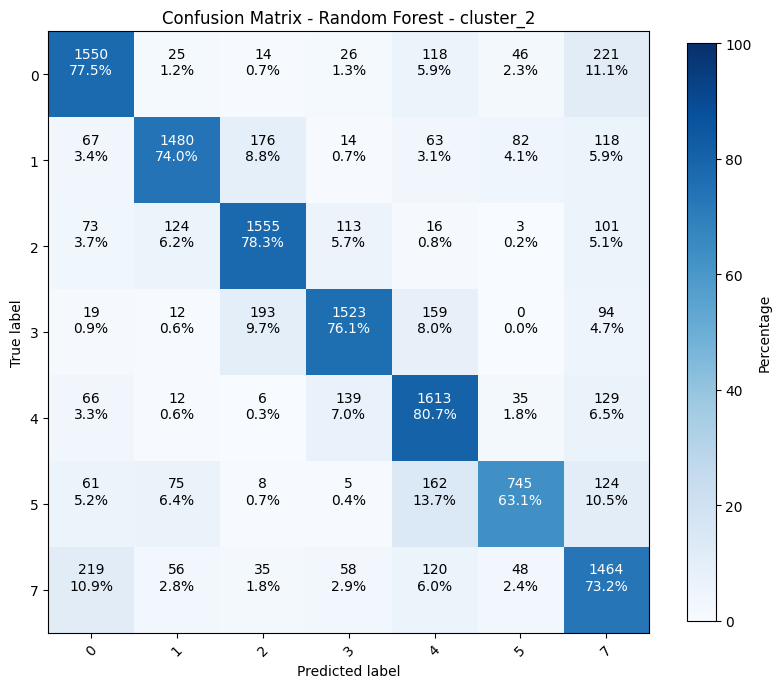

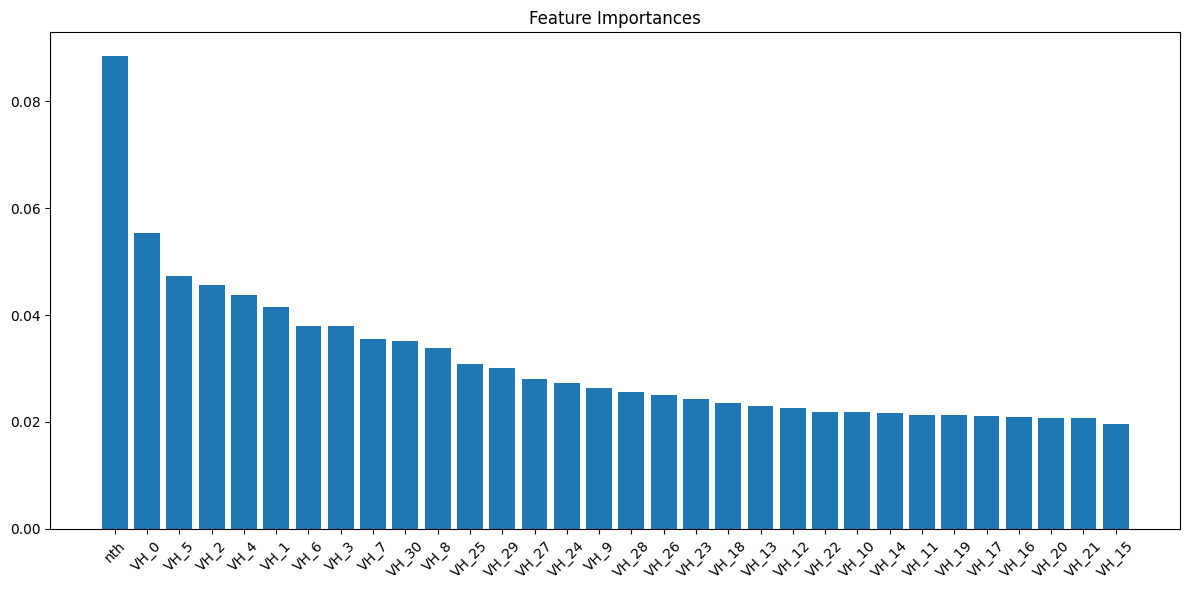

Processing Random Forest...cluster_3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    7.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    6.9s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=64)]: Using backend Threa

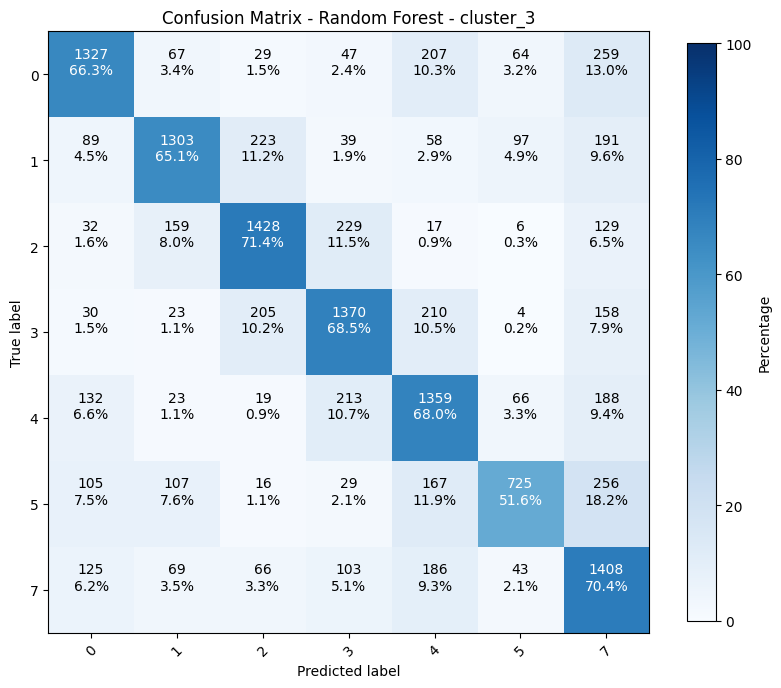

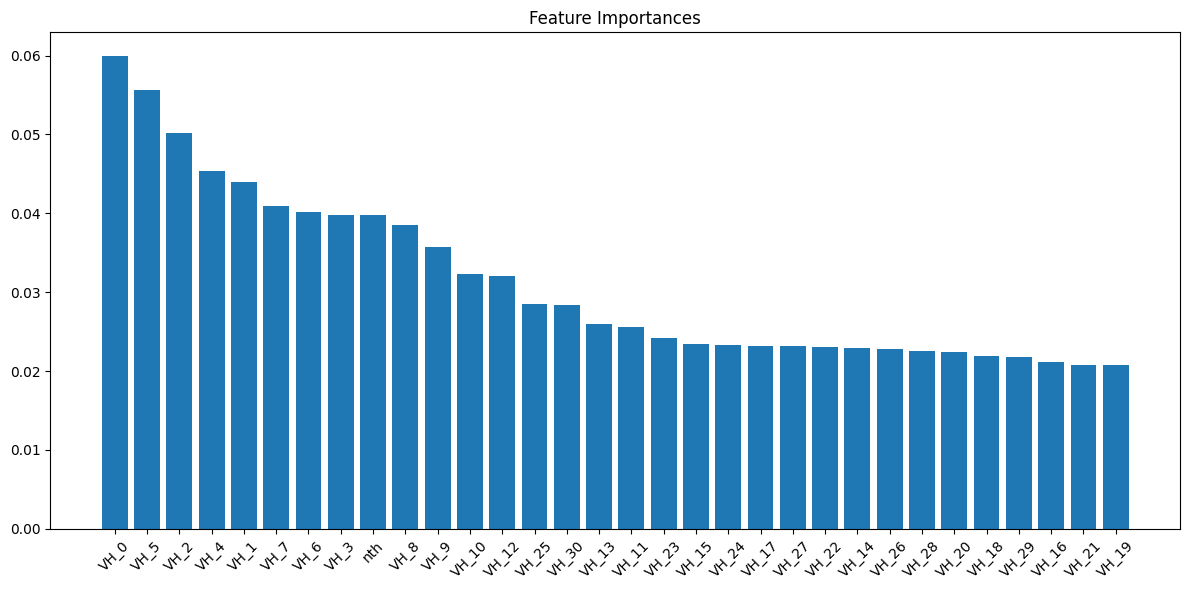

Processing Random Forest...cluster_4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    3.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    5.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    9.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    9.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=64)]: Using backend Threa

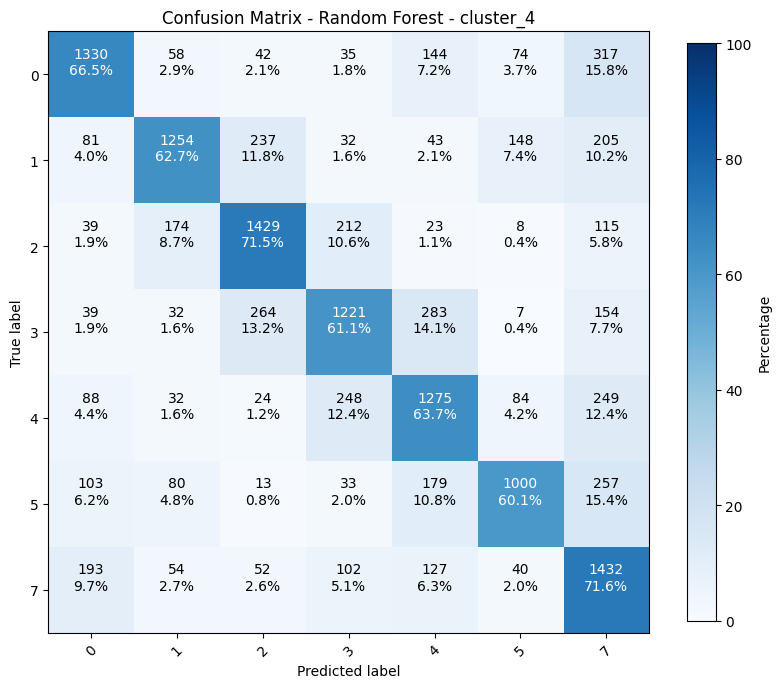

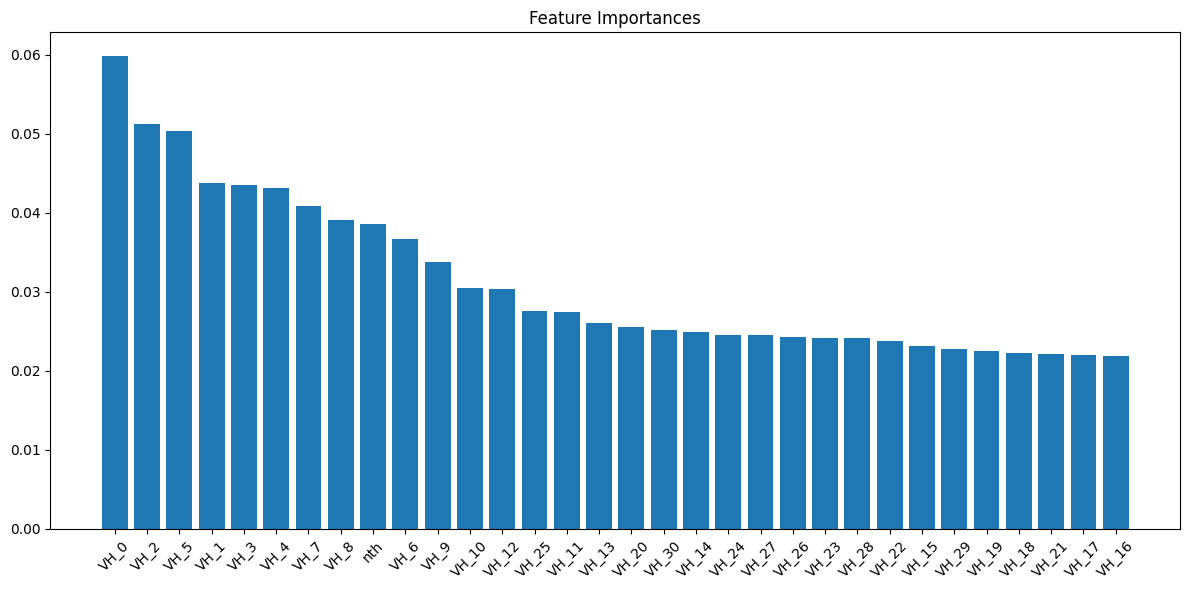

Processing Random Forest...cluster_5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    2.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    3.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    6.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  74 out of 100 | elapsed:    7.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=64)]: Using backend Threa

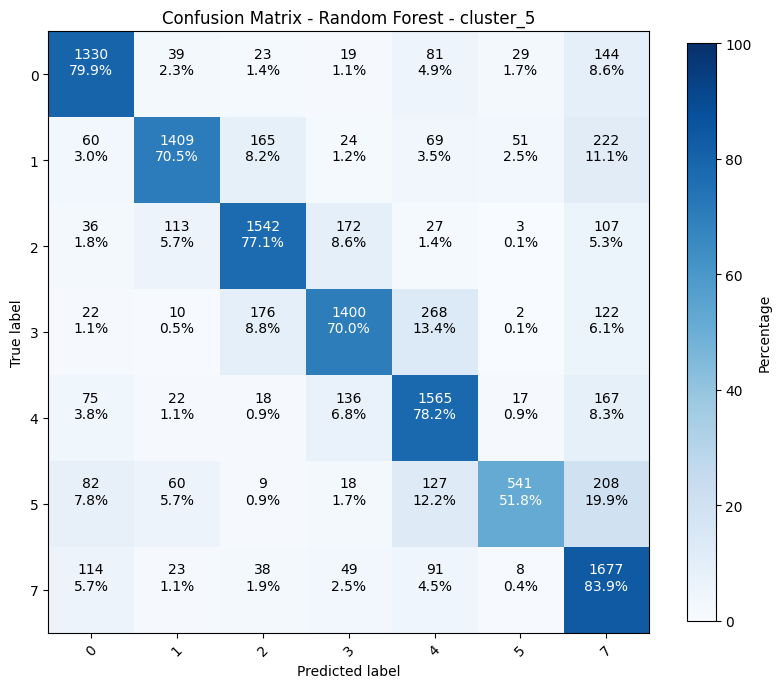

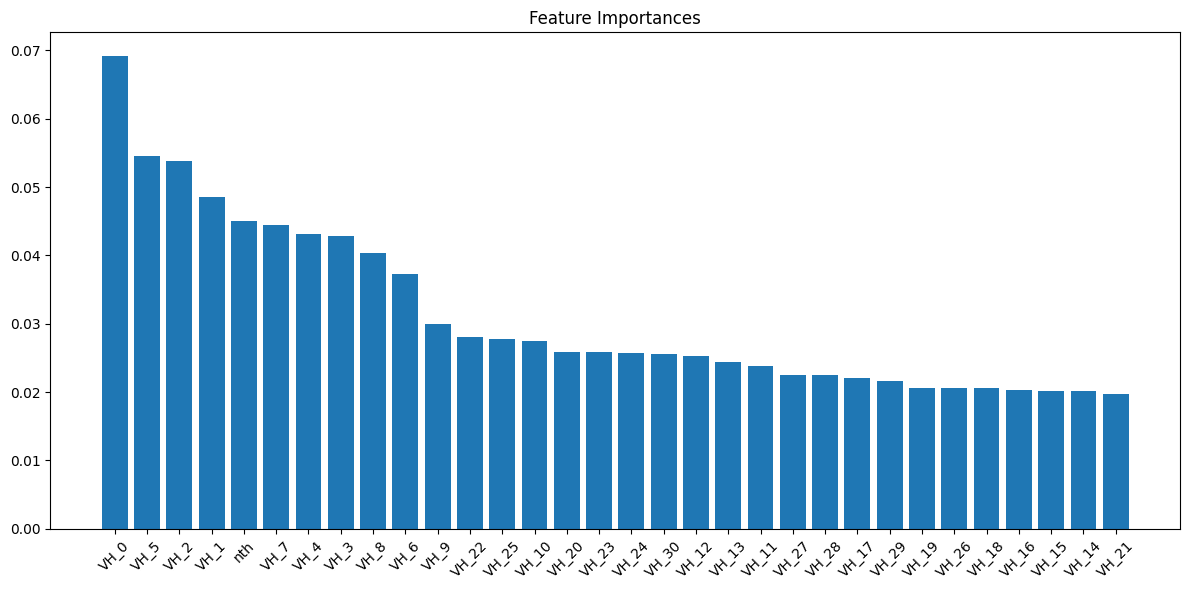

In [105]:
result_df_all = pd.DataFrame()  
model_return_dict = {}          
df_pred_dict = {}               

cluster_list = training_sampled['cluster_data'].unique()

for i in cluster_list:
    Y = training_sampled.loc[training_sampled['cluster_data'] == i, 'observation2']
    X = training_sampled.loc[training_sampled['cluster_data'] == i, var_]
    
    result_df, model_return, df_pred = modeling(Y, X, f'cluster_{i}', image=True)
    
    result_df_all = pd.concat([result_df_all, result_df], ignore_index=True)
    
    model_return_dict[f'cluster_{i}'] = model_return
    df_pred_dict[f'cluster_{i}'] = df_pred

In [110]:
result_df_all['cluster_data'] = result_df_all['Model'].str[-1:].astype(int)
result_df_all.to_csv('accuracy-recode-v2-df-random forest.csv')

result_df_all

,Model,Pred Time,Fit Time,Mean Accuracy Train (5-fold CV),Mean Accuracy Test (5-fold CV),AUC Train,AUC Test,Accuracy Testing Pred,Precision Testing Pred,Recall Testing Pred,cluster_data
0,Random Forest | cluster_0,0.100660,1.307693,0.771251,0.716484,1.0,0.961269,0.779711,0.788969,0.779711,0
1,Random Forest | cluster_1,0.085637,2.313591,0.838105,0.785012,1.0,0.982873,0.841237,0.841346,0.841237,1
2,Random Forest | cluster_2,0.097904,2.620186,0.746183,0.689328,1.0,0.960467,0.754273,0.759108,0.754273,2
3,Random Forest | cluster_3,0.100650,3.207001,0.659138,0.612234,1.0,0.925236,0.665423,0.675341,0.665423,3
4,Random Forest | cluster_4,0.209990,4.162778,0.641914,0.594438,1.0,0.920593,0.654299,0.665599,0.654299,4
5,Random Forest | cluster_5,0.086627,3.431472,0.736900,0.680094,1.0,0.952644,0.744611,0.756476,0.744611,5


### Model yang disimpan untuk prediction testing

In [111]:
model_return_dict

{'cluster_0': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_1': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_2': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_3': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_4': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_5': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)}

# **Model Utilization (Prediction on Testing Data**

In [112]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [113]:
def model_utilization(data, Y_var, X_vars, iterasi, Category, model):
    db = pd.DataFrame()
    for idx in range(0,6):
        tpt = data.loc[data[iterasi]==idx]
        Y_pred = model[f"cluster_{idx}"].predict(tpt[X_vars])
        tpt['Y_pred'] = Y_pred
        tpt['observation'] = tpt[Y_var]
        db = pd.concat([db,tpt])
        
    list_district = list(db[Category].unique())
    result = []
    
    for i in list_district:
        temp = db.loc[db[Category] == i]
        res_temp = {}
        cm = confusion_matrix(temp['observation'].astype(str), temp['Y_pred'].astype(str))
        res_temp['district'] = i
        res_temp['accuracy'] = accuracy_score(temp['observation'].astype(str), temp['Y_pred'].astype(str))
        res_temp['precision'] = precision_score(temp['observation'].astype(str), temp['Y_pred'].astype(str), average='micro')
        res_temp['recall'] = recall_score(temp['observation'].astype(str), temp['Y_pred'].astype(str), average='micro')
        res_temp['f1_macro'] = f1_score(temp[Y_var].astype(str), temp['Y_pred'].astype(str), average='macro')
        res_temp['f1_micro'] = f1_score(temp[Y_var].astype(str), temp['Y_pred'].astype(str), average='micro')
        n = cm.shape[0]
        res_temp['racc_before'] = sum(cm[i, (i+1) % n] for i in range(n)) / cm.sum()
        res_temp['racc_after'] = sum(cm[(i+1) % n, i] for i in range(n)) / cm.sum()

        if '3' in temp.loc[:,Y_var].astype(str).unique():
            class_3_index = temp[Y_var].astype(str) == '3'
            res_temp['accuracy_class_3.0'] = accuracy_score(temp[Y_var][class_3_index], temp['Y_pred'][class_3_index])
        else:
            res_temp['accuracy_class_3.0'] = None   

        result.append(res_temp)
    
    result_df = pd.DataFrame(result)
    
    return db, result_df

In [5]:
db, result_df = model_utilization(training, 'observation2', var_, 'cluster_data', 'idkab', model_return_dict)

NameError: name 'model_utilization' is not defined

### Menampilkan Hasil Per Kabupaten/Kota

In [126]:
result_df['idkab'] = result_df['district']
result_df = result_df.merge(cluster[['idkab','cluster_data']], how='right', on='idkab')
result_df.to_csv('acc_pred.csv',index=False)

result_df

,district,accuracy,precision,recall,f1_macro,f1_micro,racc_before,racc_after,accuracy_class_3.0,idkab,cluster_data_x,cluster_data_y,cluster_data
0,3201,0.451523,0.451523,0.451523,0.269422,0.451523,0.148756,0.101228,0.246230,3201,0,0,0
1,3202,0.293256,0.293256,0.293256,0.188406,0.293256,0.154041,0.124434,0.256038,3202,4,4,4
2,3203,0.331237,0.331237,0.331237,0.278284,0.331237,0.133627,0.144512,0.343740,3203,4,4,4
3,3204,0.373328,0.373328,0.373328,0.321025,0.373328,0.153139,0.098285,0.283254,3204,5,5,5
4,3205,0.325627,0.325627,0.325627,0.267736,0.325627,0.146758,0.100271,0.364101,3205,4,4,4
5,3206,0.376316,0.376316,0.376316,0.303661,0.376316,0.118245,0.138488,0.283582,3206,3,3,3
6,3207,0.357044,0.357044,0.357044,0.271604,0.357044,0.140169,0.106993,0.328421,3207,3,3,3
7,3208,0.236146,0.236146,0.236146,0.187519,0.236146,0.172960,0.123636,0.268537,3208,3,3,3
8,3209,0.472272,0.472272,0.472272,0.306287,0.472272,0.160263,0.102009,0.333130,3209,2,2,2
9,3210,0.397413,0.397413,0.397413,0.253151,0.397413,0.173055,0.089741,0.113235,3210,2,2,2


In [130]:
cluster = cluster.merge(result_df[['idkab','accuracy']], on = 'idkab',how='outer')

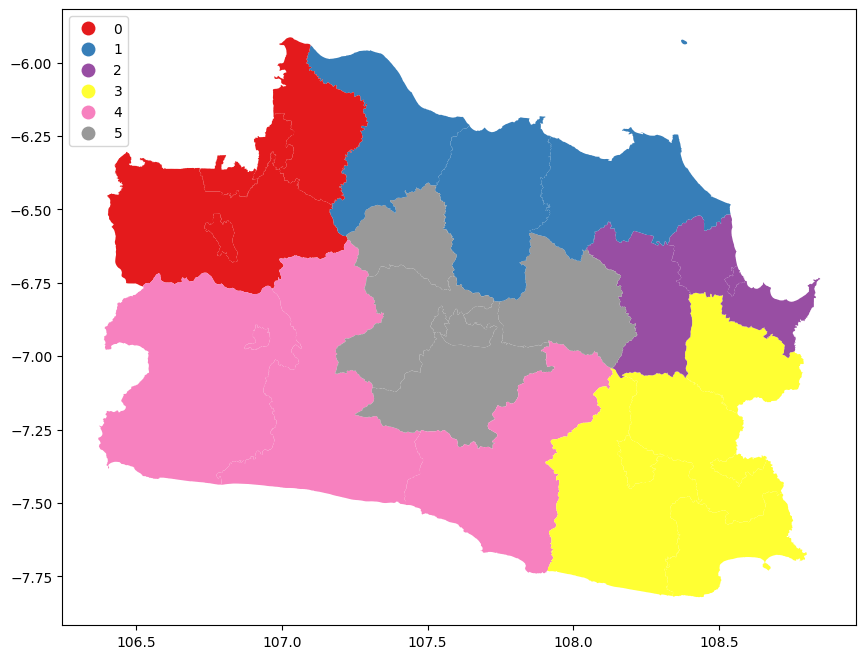

In [131]:
fig, ax = plt.subplots(figsize=(12, 8))

cluster.plot(column='cluster_data', 
             legend=True, 
             cmap='Set1',
             ax=ax, 
             categorical=True,
             legend_kwds={'loc': 'upper left'})

plt.show()

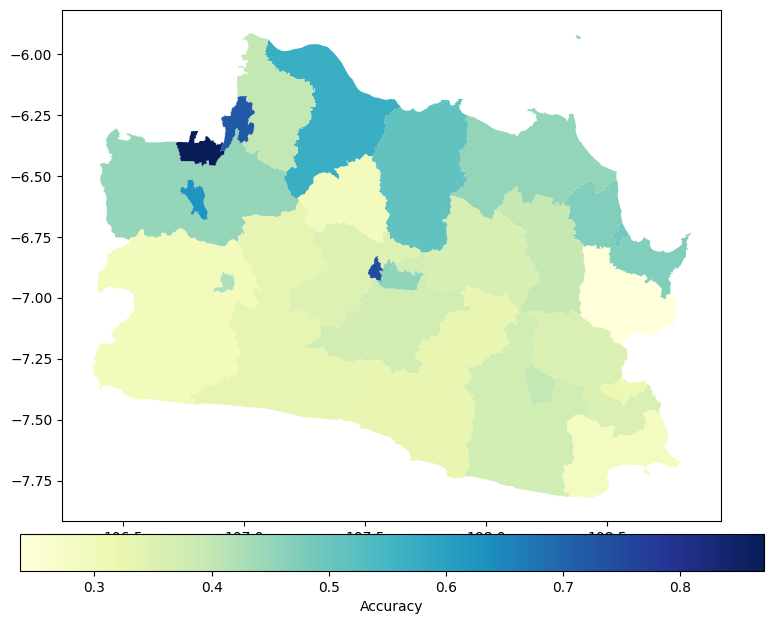

In [135]:
fig, ax = plt.subplots(figsize=(12, 8))

cluster.plot(column='accuracy_x', 
             legend=True, 
             cmap='YlGnBu',
             ax=ax, 
             legend_kwds={'label': "Accuracy",
                          'orientation': "horizontal",
                          'shrink': 0.8,
                          'pad': 0.02})

plt.show()

## Assess Prediction Each Cluster

In [137]:
db['id_periode'] = db['idsubsegment']+'#'+db['nth'].astype(str)
db.head()

,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_2,VH_1,VH_0,year,date,idkab,cluster_data,observation2,Y_pred,id_periode
0,320130009A1#01,320130009A1,320130009,10,2023_25,0,48MXU,-16.725023,-17.835718,-18.861912,...,-15.945707,-19.707195,-14.096098,23,2023-10-01,3201,0,0,0,320130009A1#10
1,320130009A1#02,320130009A1,320130009,10,2023_25,0,48MXU,-17.029100,-18.132090,-19.203442,...,-16.411623,-19.349918,-14.618581,23,2023-10-01,3201,0,0,1,320130009A1#10
2,320130009A1#03,320130009A1,320130009,10,2023_25,0,48MXU,-16.883081,-18.095416,-19.142895,...,-15.449263,-17.949583,-15.539997,23,2023-10-01,3201,0,0,0,320130009A1#10
3,320130009A1#04,320130009A1,320130009,10,2023_25,0,48MXU,-16.310753,-17.412438,-18.193932,...,-15.630909,-18.461334,-15.473708,23,2023-10-01,3201,0,0,1,320130009A1#10
4,320130009A1#05,320130009A1,320130009,10,2023_25,0,48MXU,-16.897139,-17.672377,-18.074509,...,-16.607943,-17.888708,-16.222599,23,2023-10-01,3201,0,0,0,320130009A1#10


In [138]:
pivot_table = pd.pivot_table(db, values='idpoint', index='id_periode', columns='Y_pred', aggfunc='count', fill_value=0)
pivot_table['dominant_class'] = pivot_table.idxmax(axis=1)
pivot_table = pivot_table.reset_index()
db = db.merge(pivot_table[['id_periode','dominant_class']], how='right', on='id_periode')
db.head()

,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_1,VH_0,year,date,idkab,cluster_data,observation2,Y_pred,id_periode,dominant_class
0,320101006A1#01,320101006A1,320101006,10,2023_25,0,48MXT,-14.099939,-15.445777,-17.312397,...,-20.219112,-19.063364,23,2023-10-01,3201,0,0,0,320101006A1#10,0
1,320101006A1#02,320101006A1,320101006,10,2023_25,0,48MXT,-14.966010,-16.146544,-17.527069,...,-20.317059,-17.540806,23,2023-10-01,3201,0,0,0,320101006A1#10,0
2,320101006A1#03,320101006A1,320101006,10,2023_25,0,48MXT,-14.400705,-15.470507,-16.516815,...,-19.020197,-16.970652,23,2023-10-01,3201,0,0,0,320101006A1#10,0
3,320101006A1#04,320101006A1,320101006,10,2023_25,0,48MXT,-14.757690,-15.105990,-14.937878,...,-16.975397,-16.879545,23,2023-10-01,3201,0,0,1,320101006A1#10,0
4,320101006A1#05,320101006A1,320101006,10,2023_25,0,48MXT,-15.073303,-15.037014,-14.505520,...,-18.175949,-16.840897,23,2023-10-01,3201,0,0,1,320101006A1#10,0


In [139]:
db['idx'] = db['idpoint'].str[-2:]
db_pred = db.loc[db['idx']=='13', ['idpoint', 'id_periode','observation','Y_pred','dominant_class', 'cluster_data']]
db_pred.head()

,idpoint,id_periode,observation,Y_pred,dominant_class,cluster_data
12,320101006A1#13,320101006A1#10,0,1,0,0
37,320101006A1#13,320101006A1#11,1,0,0,0
62,320101006A1#13,320101006A1#12,1,0,0,0
87,320101006A2#13,320101006A2#10,7,7,0,0
112,320101006A2#13,320101006A2#11,7,1,0,0


In [140]:
db_pred['bulan'] = db_pred['id_periode'].str[-2:]
db_pred['idsubsegmen'] = db_pred['id_periode'].str[:-3]
db_pred

,idpoint,id_periode,observation,Y_pred,dominant_class,cluster_data,bulan,idsubsegmen
12,320101006A1#13,320101006A1#10,0,1,0,0,10,320101006A1
37,320101006A1#13,320101006A1#11,1,0,0,0,11,320101006A1
62,320101006A1#13,320101006A1#12,1,0,0,0,12,320101006A1
87,320101006A2#13,320101006A2#10,7,7,0,0,10,320101006A2
112,320101006A2#13,320101006A2#11,7,1,0,0,11,320101006A2
...,...,...,...,...,...,...,...,...
1503987,327904003C2#13,327904003C2#11,0,0,0,3,11,327904003C2
1504012,327904003C2#13,327904003C2#12,5,3,3,3,12,327904003C2
1504037,327904003C3#13,327904003C3#10,0,0,0,3,10,327904003C3
1504062,327904003C3#13,327904003C3#11,0,5,0,3,11,327904003C3


## Buat Kak Aldi

In [141]:
db_pred.to_csv('to_estimate.csv')

In [143]:
db_pred[['observation','Y_pred','dominant_class']] = db_pred[['observation','Y_pred','dominant_class']].astype(str)

### **Hasil Titik Tengah**

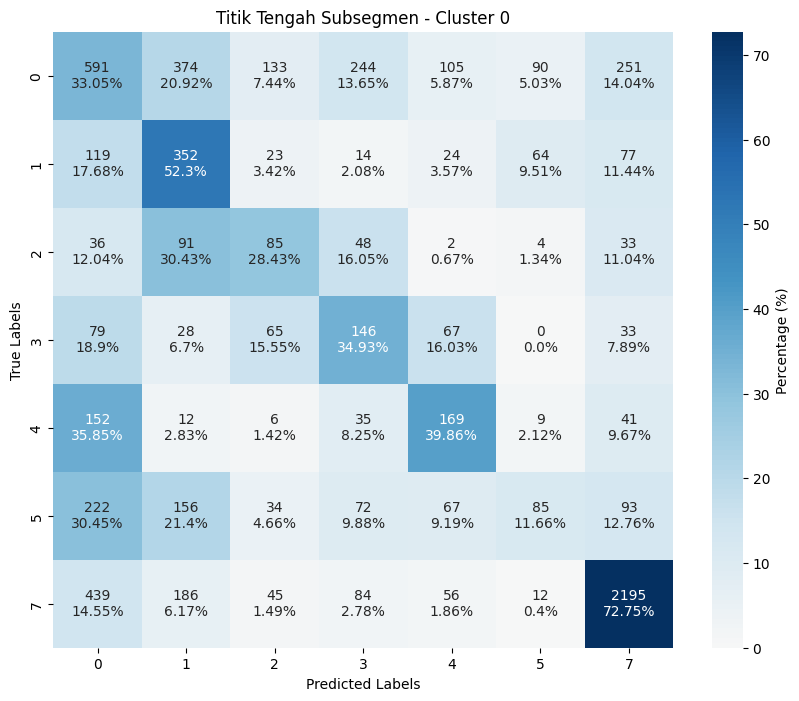

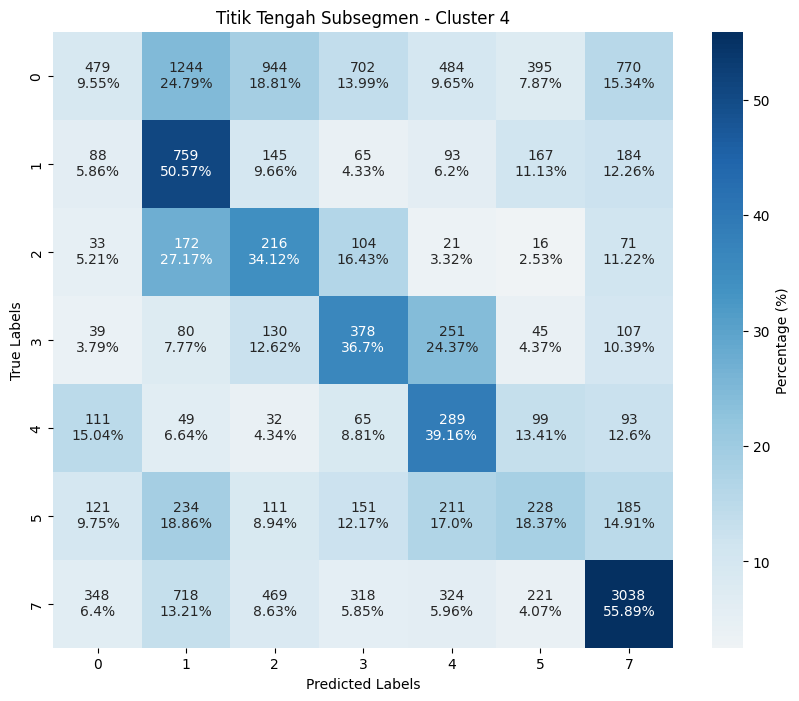

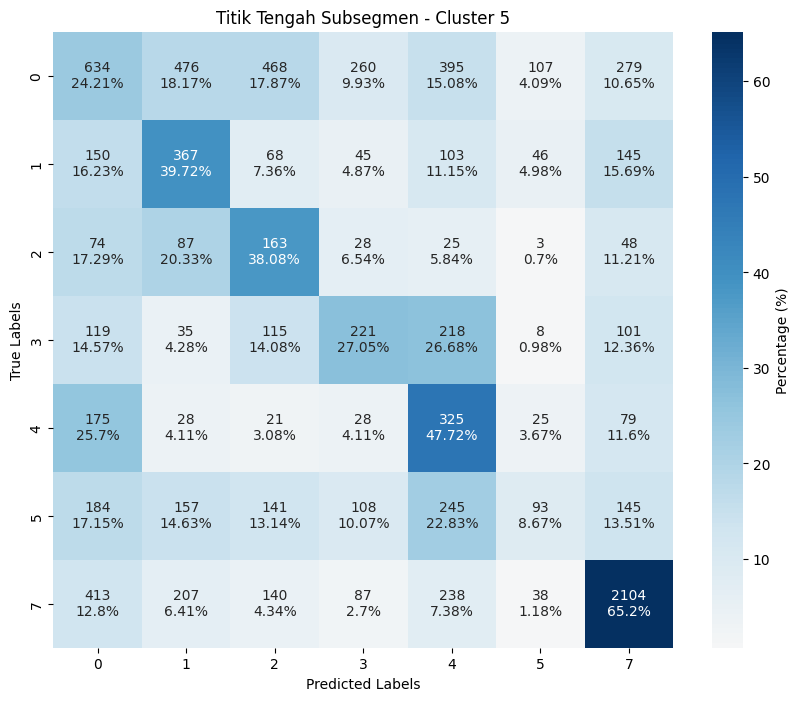

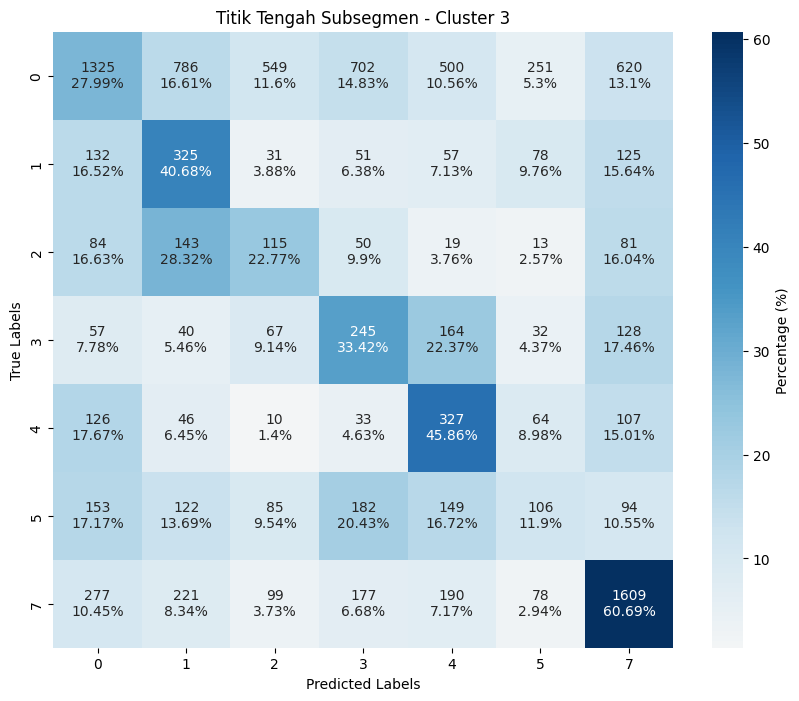

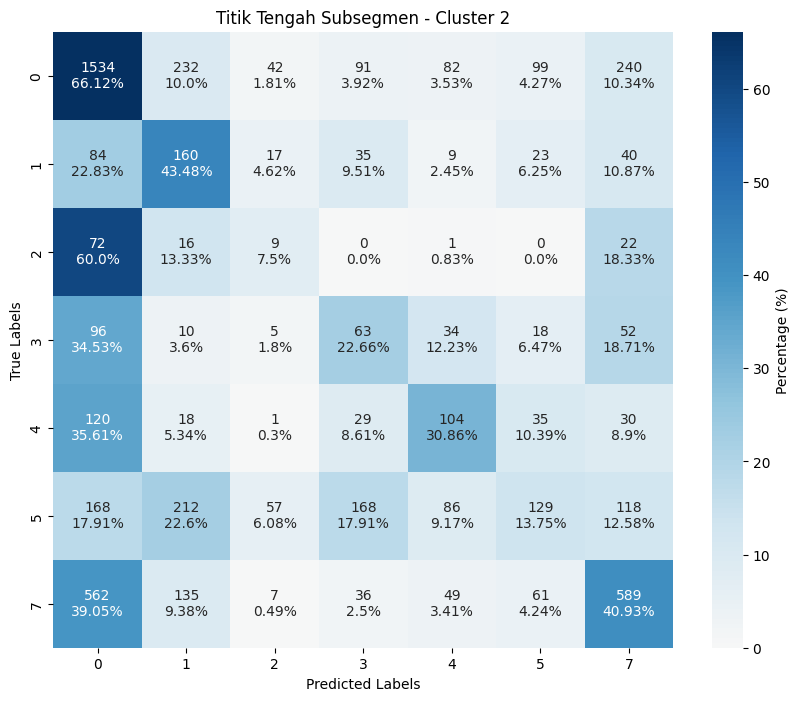

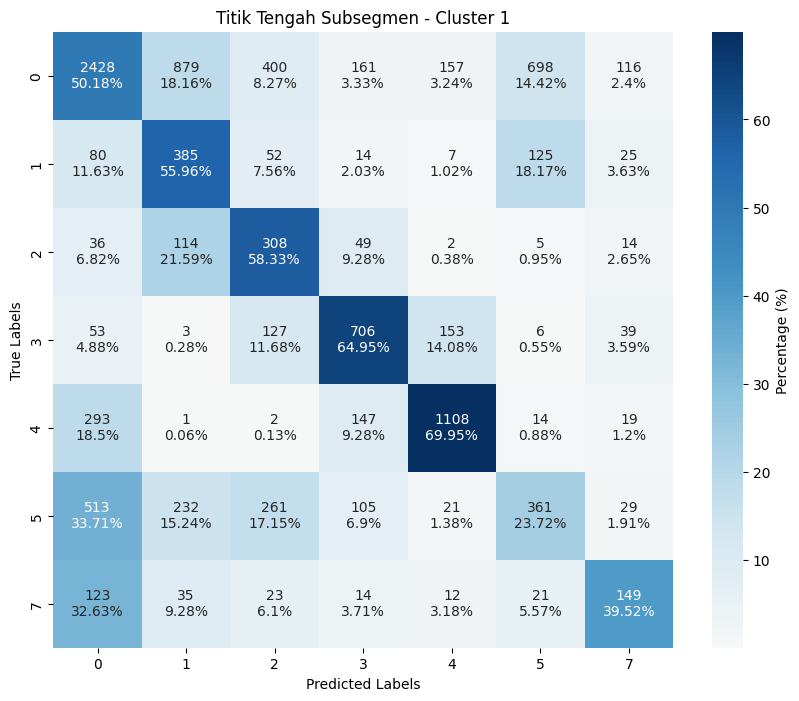

In [148]:
results = []

classes_1_4 = ['1', '2', '3', '4']

for cluster in db_pred['cluster_data'].unique():
    cluster_data = db_pred[db_pred['cluster_data'] == cluster]
    pivot = pd.pivot_table(cluster_data, values='idpoint', index='observation', columns='Y_pred', aggfunc='count', fill_value=0)
    pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0) * 100
    labels = pivot.astype(str) + "\n" + pivot_percentage.round(2).astype(str) + "%"

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_percentage, annot=labels, fmt='', cmap="RdBu", cbar_kws={'label': 'Percentage (%)'}, center=0)
    plt.title(f"Titik Tengah Subsegmen - Cluster {cluster}")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

    correct_predictions = np.diag(pivot).sum()
    total_observations = pivot.values.sum()
    overall_accuracy = correct_predictions / total_observations

    if set(classes_1_4).issubset(pivot.index) and set(classes_1_4).issubset(pivot.columns):
        class_correct_1_4 = pivot.loc[classes_1_4, classes_1_4].values.diagonal().sum()
        class_total_1_4 = pivot.loc[classes_1_4].sum().sum()
        class_accuracy_1_4 = class_correct_1_4 / class_total_1_4
    else:
        class_accuracy_1_4 = np.nan
        
    class_accuracies = {}
    for cls in classes_1_4 + ['5', '7']:
        if cls in pivot.index and cls in pivot.columns:
            class_correct_single = pivot.loc[cls, cls]
            class_total_single = pivot.loc[cls].sum()
            class_accuracy = class_correct_single / class_total_single if class_total_single > 0 else np.nan
        else:
            class_accuracy = np.nan
        class_accuracies[cls] = class_accuracy

    result = {
        'Cluster': cluster,
        'Overall Accuracy': overall_accuracy,
        'Accuracy (1, 2, 3, 4)': class_accuracy_1_4,
        'Accuracy Class 1': class_accuracies['1'],
        'Accuracy Class 2': class_accuracies['2'],
        'Accuracy Class 3': class_accuracies['3'],
        'Accuracy Class 4': class_accuracies['4'],
        'Accuracy Class 5': class_accuracies['5'],
        'Accuracy Class 7': class_accuracies['7']
    }
    
    results.append(result)

accuracy_df = pd.DataFrame(results)

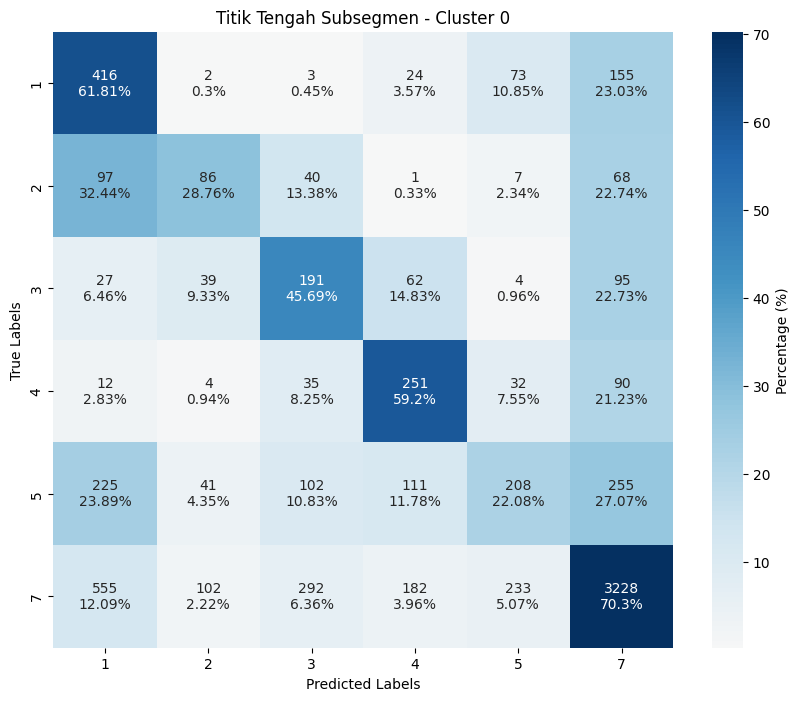

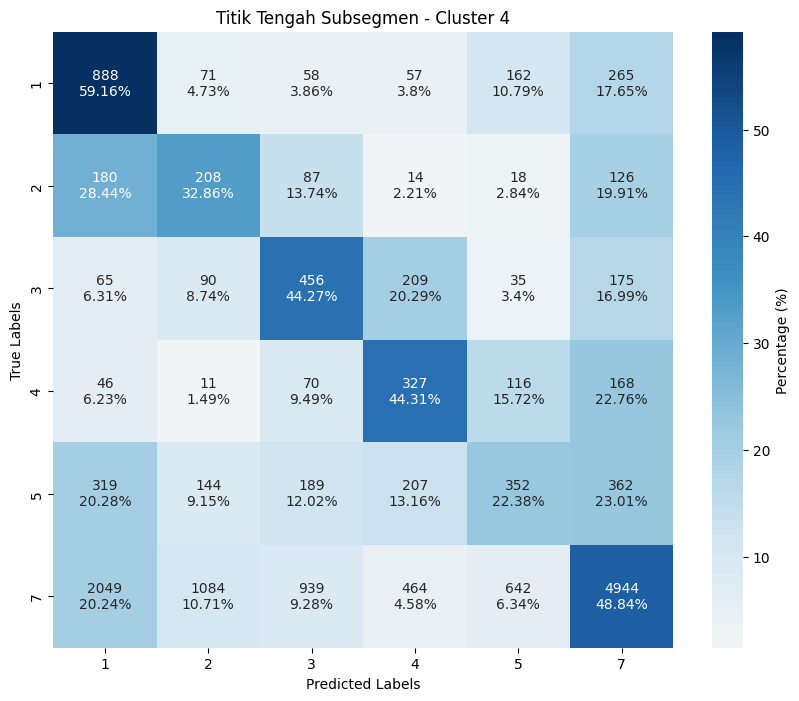

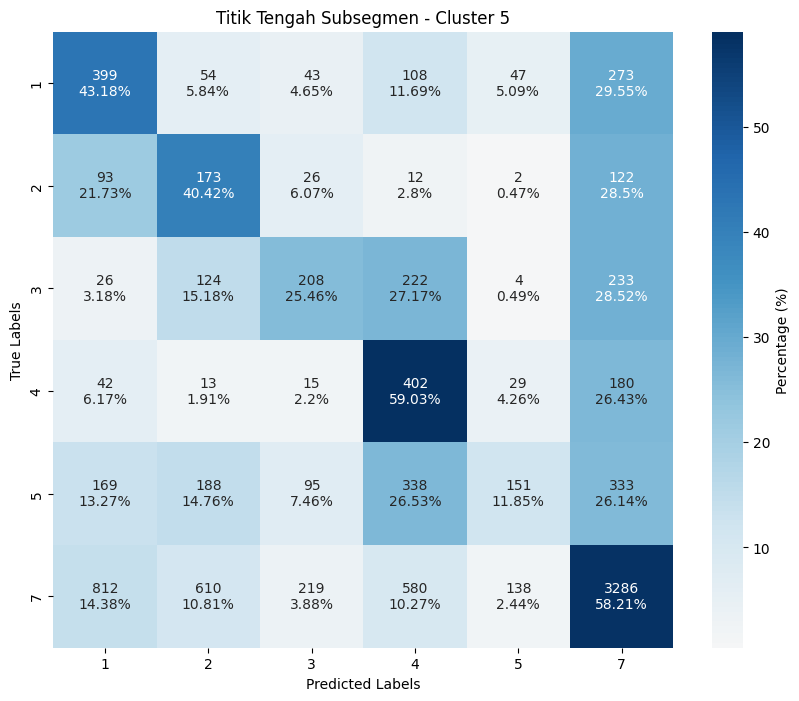

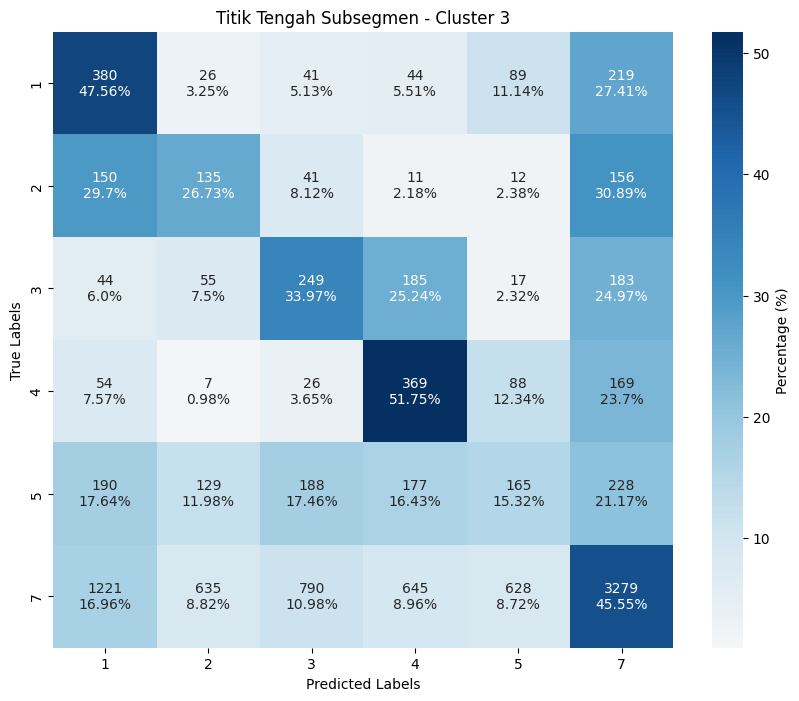

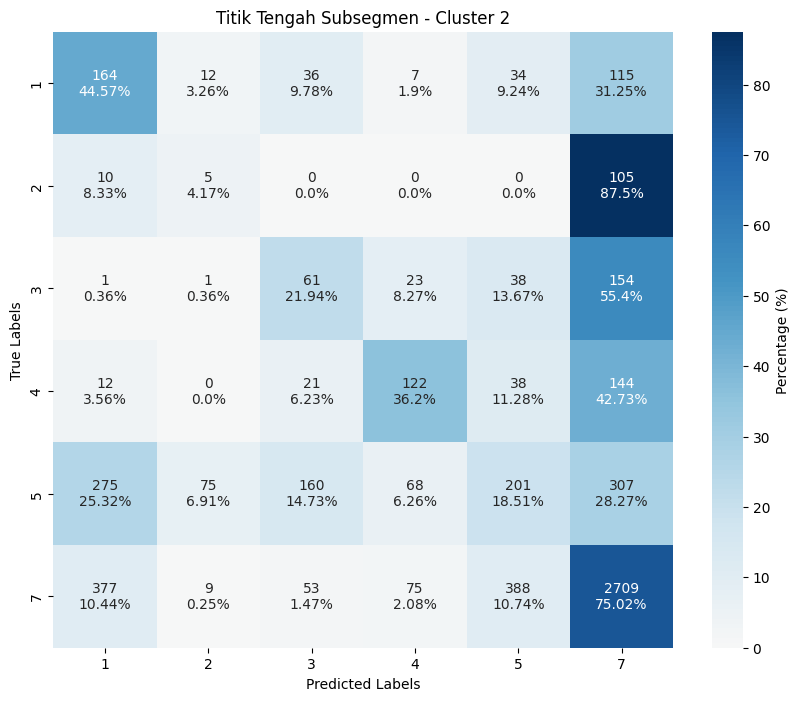

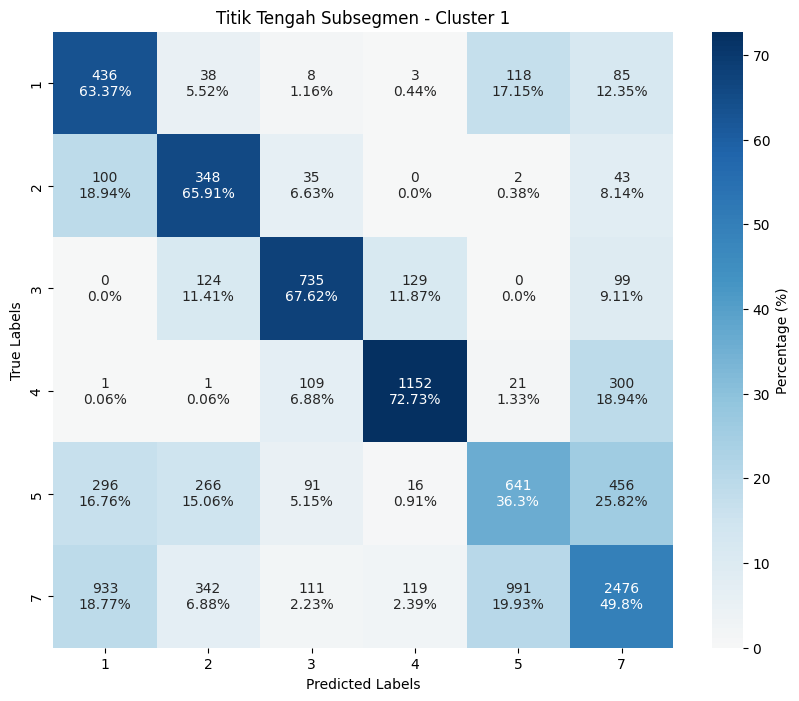

   Cluster  Overall Accuracy  Accuracy (1, 2, 3, 4)  Accuracy Class 1  \
0        0          0.596081               0.520397          0.618128   
1        4          0.460024               0.481548          0.591606   
2        5          0.472822               0.414737          0.431818   
3        3          0.415147               0.412000          0.475594   
4        2          0.562414               0.319130          0.445652   
5        1          0.544753               0.687162          0.633721   

   Accuracy Class 2  Accuracy Class 3  Accuracy Class 4  Accuracy Class 5  \
0          0.287625          0.456938          0.591981          0.220807   
1          0.328594          0.442718          0.443089          0.223776   
2          0.404206          0.254590          0.590308          0.118524   
3          0.267327          0.339700          0.517532          0.153203   
4          0.041667          0.219424          0.362018          0.185083   
5          0.659091       

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare an empty list to store results
results = []

# Define the updated list of classes
classes_1_4 = ['1', '2', '3', '4']

# Iterate through each unique category in 'cluster_data'
for cluster in db_pred['cluster_data'].unique():
    # Filter the data for the current cluster
    cluster_data = db_pred[db_pred['cluster_data'] == cluster]
    
    # Create a pivot table for the current cluster
    pivot = pd.pivot_table(cluster_data, values='idpoint', index='observation', columns='dominant_class', aggfunc='count', fill_value=0)
    pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0) * 100
    labels = pivot.astype(str) + "\n" + pivot_percentage.round(2).astype(str) + "%"

    # Plot heatmap for the current cluster
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_percentage, annot=labels, fmt='', cmap="RdBu", cbar_kws={'label': 'Percentage (%)'}, center=0)
    plt.title(f"Titik Tengah Subsegmen - Cluster {cluster}")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

    # Calculate overall accuracy for the current cluster
    correct_predictions = np.diag(pivot).sum()
    total_observations = pivot.values.sum()
    overall_accuracy = correct_predictions / total_observations

    # Calculate accuracy for classes 1, 2, 3, 4 only
    if set(classes_1_4).issubset(pivot.index) and set(classes_1_4).issubset(pivot.columns):
        class_correct_1_4 = pivot.loc[classes_1_4, classes_1_4].values.diagonal().sum()
        class_total_1_4 = pivot.loc[classes_1_4].sum().sum()
        class_accuracy_1_4 = class_correct_1_4 / class_total_1_4
    else:
        class_accuracy_1_4 = np.nan
        
    # Calculate accuracy for each class individually
    class_accuracies = {}
    for cls in classes_1_4 + ['5', '7']:  # Including classes 5 and 7 for individual accuracy
        if cls in pivot.index and cls in pivot.columns:
            class_correct_single = pivot.loc[cls, cls]
            class_total_single = pivot.loc[cls].sum()
            class_accuracy = class_correct_single / class_total_single if class_total_single > 0 else np.nan
        else:
            class_accuracy = np.nan
        class_accuracies[cls] = class_accuracy

    # Store the results in a dictionary
    result = {
        'Cluster': cluster,
        'Overall Accuracy': overall_accuracy,
        'Accuracy (1, 2, 3, 4)': class_accuracy_1_4,
        'Accuracy Class 1': class_accuracies['1'],
        'Accuracy Class 2': class_accuracies['2'],
        'Accuracy Class 3': class_accuracies['3'],
        'Accuracy Class 4': class_accuracies['4'],
        'Accuracy Class 5': class_accuracies['5'],
        'Accuracy Class 7': class_accuracies['7']
    }
    
    # Append the result to the list
    results.append(result)

# Convert the list of dictionaries into a DataFrame
accuracy_df = pd.DataFrame(results)

# Display the final DataFrame
print(accuracy_df)

In [67]:
accuracy_df.to_csv('d_class.csv')